In [ ]:
import math

# Battery parameters
Q_max = 100  # Initial capacity in Ah
I = 5  # Current drawn from the battery in A
k_calendar = 0.0001  # Calendar aging factor (small number)
k_cycle_base = 0.01  # Base cycle aging factor
alpha_DoD = 1.5  # Depth of Discharge sensitivity factor
k_temp = 0.001  # Temperature sensitivity factor
T_optimal = 25  # Optimal temperature in Celsius

# Simulate for different cycles, calendar time, and temperature
for cycle in range(0, 101):  # Simulate 100 cycles
    T_current = 40  # Let's assume it's 40°C (hot)

    # Depth of Discharge for this cycle (we'll assume full discharge for simplicity)
    DoD = 1.0  # Full discharge (can vary between 0 and 1)

    # Capacity reduction due to aging (calendar and cycle aging combined)
    t = cycle / 365  # Assume one cycle per day (1 cycle = 1 day)
    k_cycle = k_cycle_base * DoD**alpha_DoD  # Adjust cycle aging based on DoD
    Q_max_aged = Q_max * (1 - k_calendar * t - k_cycle * cycle)  # Combined aging

    # Nonlinear temperature effect (quadratic)
    Q_max_temp = Q_max_aged * (1 - k_temp * (T_current - T_optimal)**2)

    # Remaining charge after 2 hours of usage
    Q_remaining = Q_max_temp - (I * 2)
    if Q_remaining < 0:
        Q_remaining = 0  # Battery can't have negative charge

    SoC = (Q_remaining / Q_max_temp) * 100
    print(f"Cycle {cycle}: Q_max_temp = {Q_max_temp:.2f} Ah, SoC = {SoC:.2f}%")


Cycle 0: Q_max_temp = 77.50 Ah, SoC = 87.10%
Cycle 1: Q_max_temp = 76.72 Ah, SoC = 86.97%
Cycle 2: Q_max_temp = 75.95 Ah, SoC = 86.83%
Cycle 3: Q_max_temp = 75.17 Ah, SoC = 86.70%
Cycle 4: Q_max_temp = 74.40 Ah, SoC = 86.56%
Cycle 5: Q_max_temp = 73.62 Ah, SoC = 86.42%
Cycle 6: Q_max_temp = 72.85 Ah, SoC = 86.27%
Cycle 7: Q_max_temp = 72.07 Ah, SoC = 86.13%
Cycle 8: Q_max_temp = 71.30 Ah, SoC = 85.97%
Cycle 9: Q_max_temp = 70.52 Ah, SoC = 85.82%
Cycle 10: Q_max_temp = 69.75 Ah, SoC = 85.66%
Cycle 11: Q_max_temp = 68.97 Ah, SoC = 85.50%
Cycle 12: Q_max_temp = 68.20 Ah, SoC = 85.34%
Cycle 13: Q_max_temp = 67.42 Ah, SoC = 85.17%
Cycle 14: Q_max_temp = 66.65 Ah, SoC = 85.00%
Cycle 15: Q_max_temp = 65.87 Ah, SoC = 84.82%
Cycle 16: Q_max_temp = 65.10 Ah, SoC = 84.64%
Cycle 17: Q_max_temp = 64.32 Ah, SoC = 84.45%
Cycle 18: Q_max_temp = 63.55 Ah, SoC = 84.26%
Cycle 19: Q_max_temp = 62.77 Ah, SoC = 84.07%
Cycle 20: Q_max_temp = 62.00 Ah, SoC = 83.87%
Cycle 21: Q_max_temp = 61.22 Ah, SoC = 83.67

Basic RC model implementation

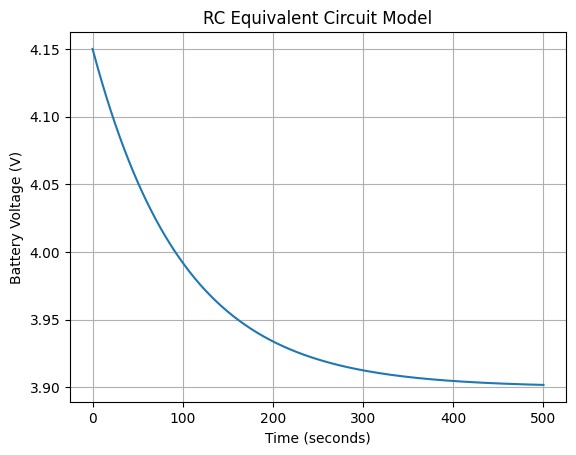

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# RC model parameters
R0 = 0.01  # Internal resistance in ohms
R1 = 0.05  # Dynamic resistance in ohms
C1 = 2000  # Capacitance in Farads
I = 5  # Current in Amperes
V_oc = 4.2  # Open circuit voltage in volts

# Time vector (in seconds)
time = np.linspace(0, 500, 500)

# Calculate the voltage response over time
V_battery = V_oc - I * R0 - I * R1 * (1 - np.exp(-time / (R1 * C1)))

# Plot the results
plt.plot(time, V_battery)
plt.xlabel('Time (seconds)')
plt.ylabel('Battery Voltage (V)')
plt.title('RC Equivalent Circuit Model')
plt.grid(True)
plt.show()


Curve fitting code in python - I just realised that the curve above is well, a curve and we can use curvefitting bruteforcing which is a function under Scikit.

Fitted values: R1 = 0.0517 ohms, C1 = 275.170 F


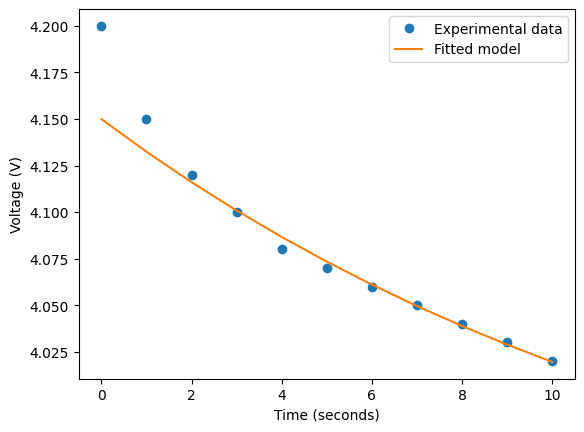

In [ ]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt


def rc_model(t, R1, C1, R0, I, V_oc):
    return V_oc - I * R0 - I * R1 * (1 - np.exp(-t / (R1 * C1)))

# Example experimental data (time in seconds, voltage in volts), we would need
# to change this to add the actual data from Chaitali ma'am here. Please take
# care to only take in the open circuit V data with respect to time for the
# arrays below
time = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])  # Time in seconds
voltage = np.array([4.2, 4.15, 4.12, 4.1, 4.08, 4.07, 4.06, 4.05, 4.04, 4.03, 4.02])
# Measured open circuit voltage in volts

# Initial guess for R1 and C1 (and known R0, I, V_oc)
R0 = 0.01  # Internal resistance from previous step
I = 5  # Applied current in Amps
V_oc = 4.2  # Open-circuit voltage in volts
initial_guess = [0.05, 2000]  # Initial guesses for R1 and C1

# Fit the model to the data
params, covariance = curve_fit(lambda t, R1, C1: rc_model(t, R1, C1, R0, I, V_oc), time, voltage, p0=initial_guess)
# R0 is constant, and so is the current since the Voc can only be measured at a
# static current. The only unknown variables are therefore R1 and C1, which can
# be found by curvematching to the standard equation of a battery. This is
# essentially a very powerful bruteforcing algorithm based on reduction of SSEs
# (sum of squared errors) and should only be run on powerful enough computers to
# calculate R1 and C1 of unknown batteries. The computation cost is high and it
# would only increase more as we add in larger dataset.

# Extract the fitted R1 and C1 values
R1_fitted, C1_fitted = params
print(f"Fitted values: R1 = {R1_fitted:.4f} ohms, C1 = {C1_fitted:.3f} F")
# The .4f and .3f represent the precision of values - the Resistance is going to
# be small therefore we have precision of 4 values after decimal

# Plot the fitted model against experimental data
voltage_fitted = rc_model(time, R1_fitted, C1_fitted, R0, I, V_oc)
plt.plot(time, voltage, 'o', label='Experimental data')
plt.plot(time, voltage_fitted, '-', label='Fitted model')
plt.xlabel('Time (seconds)')
plt.ylabel('Voltage (V)')
plt.legend()
plt.show()


In [ ]:
import numpy as np
from scipy.optimize import curve_fit

# Time and voltage data from experiments
time = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
voltage = np.array([4.2, 4.15, 4.12, 4.1, 4.08, 4.07, 4.06, 4.05, 4.04, 4.03, 4.02])

# Known parameters
R0 = 0.01  # Internal resistance
I = 5  # Applied current

# First-order RC components
R1 = 0.0517  # Fast transient resistance
C1 = 275.170  # Fast transient capacitance

# Define second-order RC model equation
def second_order_rc_model(t, R1, C1, R2, C2, V_oc):
    return V_oc - I * R0 - I * R1 * (1 - np.exp(-t / (R1 * C1))) - I * R2 * (1 - np.exp(-t / (R2 * C2)))

# Initial guesses for R2 and C2
initial_guess = [R1, C1, 0.1, 4000, 4.2]  # Guess R2 and C2

# Curve fit the second-order RC model to the voltage data
params, _ = curve_fit(second_order_rc_model, time, voltage, p0=initial_guess)

# Extract fitted parameters
R1_fitted, C1_fitted, R2_fitted, C2_fitted, V_oc_fitted = params

print(f"Fitted Parameters: R1 = {R1_fitted}, C1 = {C1_fitted}, R2 = {R2_fitted}, C2 = {C2_fitted}, V_oc = {V_oc_fitted}")


Fitted Parameters: R1 = 0.01762680158211879, C1 = 92.52961582183084, R2 = 103.61593494533928, C2 = 547.6664158900188, V_oc = 4.2499555683151


Fitted Parameters:
R1 = 0.0176 ohms
C1 = 92.53 farads
R2 = 103.6159 ohms
C2 = 547.67 farads
V_oc = 4.2500 volts


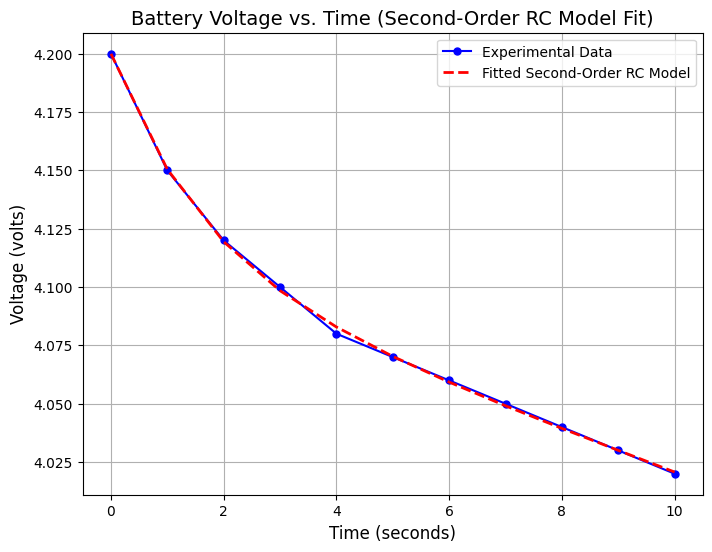

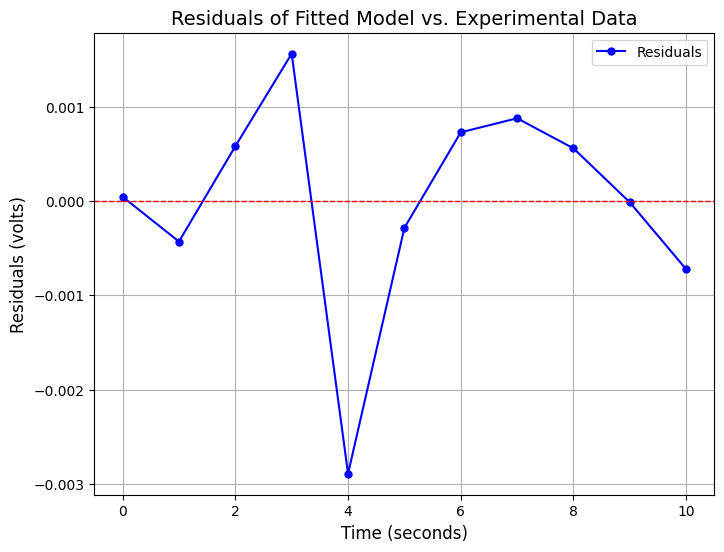

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Experimental time (in seconds) and voltage data
time = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
voltage = np.array([4.2, 4.15, 4.12, 4.1, 4.08, 4.07, 4.06, 4.05, 4.04, 4.03, 4.02])

# Known parameters
R0 = 0.01  # Internal resistance (ohms)
I = 5      # Applied current (amps)

# First-order RC components (initially known or estimated)
R1 = 0.0517  # Fast transient resistance (ohms)
C1 = 275.170  # Fast transient capacitance (farads)

# Define the second-order RC model equation
def second_order_rc_model(t, R1, C1, R2, C2, V_oc):
    return V_oc - I * R0 - I * R1 * (1 - np.exp(-t / (R1 * C1))) - I * R2 * (1 - np.exp(-t / (R2 * C2)))

# Initial guesses for R2 and C2 and open-circuit voltage V_oc
initial_guess = [R1, C1, 0.1, 4000, 4.2]  # Initial guesses: R2, C2, and Voc

# Curve fitting the second-order RC model to the experimental voltage data
params, covariance = curve_fit(second_order_rc_model, time, voltage, p0=initial_guess)

# Extracting the fitted parameters
R1_fitted, C1_fitted, R2_fitted, C2_fitted, V_oc_fitted = params

# Generate fitted voltage data using the fitted parameters
voltage_fitted = second_order_rc_model(time, R1_fitted, C1_fitted, R2_fitted, C2_fitted, V_oc_fitted)

# Print the fitted parameter values
print(f"Fitted Parameters:\nR1 = {R1_fitted:.4f} ohms\nC1 = {C1_fitted:.2f} farads")
print(f"R2 = {R2_fitted:.4f} ohms\nC2 = {C2_fitted:.2f} farads")
print(f"V_oc = {V_oc_fitted:.4f} volts")

# Plot the experimental and fitted data
plt.figure(figsize=(8, 6))

# Plot experimental voltage data
plt.plot(time, voltage, 'bo-', label='Experimental Data', markersize=5)

# Plot fitted voltage data from the second-order RC model
plt.plot(time, voltage_fitted, 'r--', label='Fitted Second-Order RC Model', linewidth=2)

# Add labels and title
plt.xlabel('Time (seconds)', fontsize=12)
plt.ylabel('Voltage (volts)', fontsize=12)
plt.title('Battery Voltage vs. Time (Second-Order RC Model Fit)', fontsize=14)

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

# Plot the residuals (difference between experimental and fitted voltage)
residuals = voltage - voltage_fitted

plt.figure(figsize=(8, 6))
plt.plot(time, residuals, 'bo-', label='Residuals', markersize=5)
plt.axhline(0, color='r', linestyle='--', linewidth=1)

# Add labels and title
plt.xlabel('Time (seconds)', fontsize=12)
plt.ylabel('Residuals (volts)', fontsize=12)
plt.title('Residuals of Fitted Model vs. Experimental Data', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()


Fitted Parameters:
R1 = 0.0514 ohms
C1 = 275.84 farads
R2 = 0.1587 ohms
C2 = 110597.35 farads
Fixed V_oc = 4.2 volts


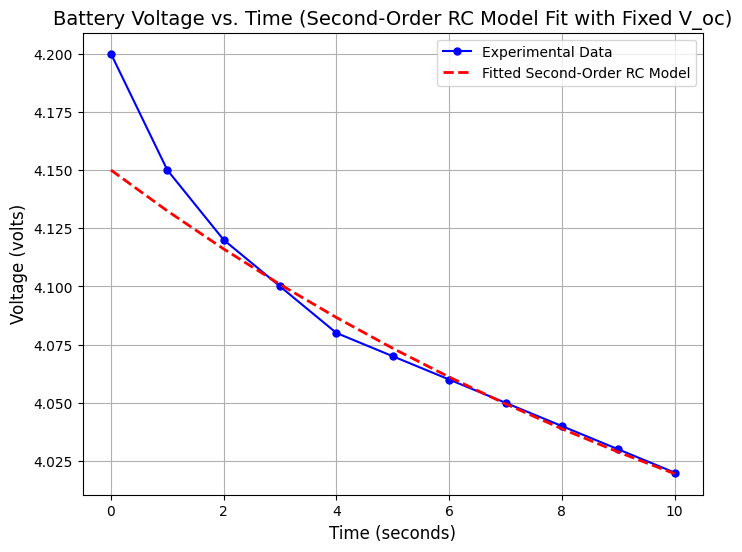

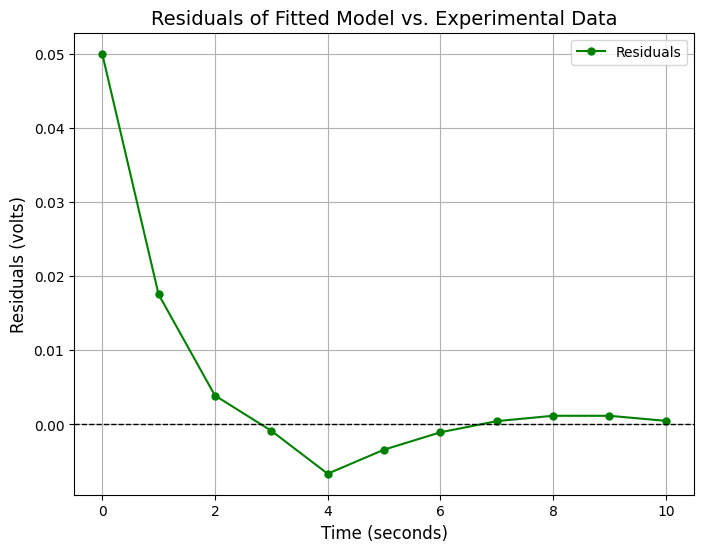

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Experimental time (in seconds) and voltage data
time = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
voltage = np.array([4.2, 4.15, 4.12, 4.1, 4.08, 4.07, 4.06, 4.05, 4.04, 4.03, 4.02])

# Known parameters
R0 = 0.01  # Internal resistance (ohms)
I = 5      # Applied current (amps)
V_oc = 4.2  # Known open-circuit voltage (volts), set constant

# First-order RC components (initially known or estimated)
R1 = 0.0517  # Fast transient resistance (ohms)
C1 = 275.170  # Fast transient capacitance (farads)

# Define the second-order RC model equation with a fixed V_oc
def second_order_rc_model(t, R1, C1, R2, C2):
    return V_oc - I * R0 - I * R1 * (1 - np.exp(-t / (R1 * C1))) - I * R2 * (1 - np.exp(-t / (R2 * C2)))

# Initial guesses for R2 and C2
initial_guess = [R1, C1, 0.1, 4000]  # Initial guesses for R2, C2

# Curve fitting the second-order RC model to the experimental voltage data
params, covariance = curve_fit(second_order_rc_model, time, voltage, p0=initial_guess)

# Extracting the fitted parameters
R1_fitted, C1_fitted, R2_fitted, C2_fitted = params

# Generate fitted voltage data using the fitted parameters
voltage_fitted = second_order_rc_model(time, R1_fitted, C1_fitted, R2_fitted, C2_fitted)

# Print the fitted parameter values
print(f"Fitted Parameters:\nR1 = {R1_fitted:.4f} ohms\nC1 = {C1_fitted:.2f} farads")
print(f"R2 = {R2_fitted:.4f} ohms\nC2 = {C2_fitted:.2f} farads")
print(f"Fixed V_oc = {V_oc} volts")

# Plot the experimental and fitted data
plt.figure(figsize=(8, 6))

# Plot experimental voltage data
plt.plot(time, voltage, 'bo-', label='Experimental Data', markersize=5)

# Plot fitted voltage data from the second-order RC model
plt.plot(time, voltage_fitted, 'r--', label='Fitted Second-Order RC Model', linewidth=2)

# Add labels and title
plt.xlabel('Time (seconds)', fontsize=12)
plt.ylabel('Voltage (volts)', fontsize=12)
plt.title('Battery Voltage vs. Time (Second-Order RC Model Fit with Fixed V_oc)', fontsize=14)

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

# Plot the residuals (difference between experimental and fitted voltage)
residuals = voltage - voltage_fitted

plt.figure(figsize=(8, 6))
plt.plot(time, residuals, 'go-', label='Residuals', markersize=5)
plt.axhline(0, color='k', linestyle='--', linewidth=1)

# Add labels and title
plt.xlabel('Time (seconds)', fontsize=12)
plt.ylabel('Residuals (volts)', fontsize=12)
plt.title('Residuals of Fitted Model vs. Experimental Data', fontsize=14)

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


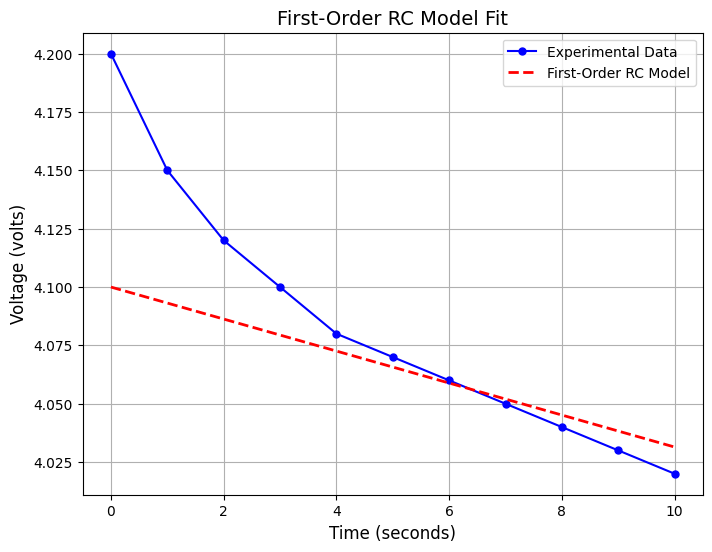

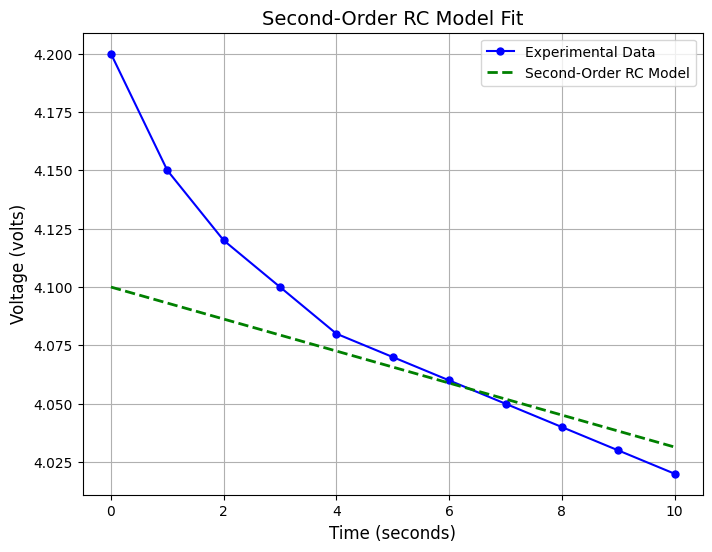

First-Order RC Model Fitted Parameters:
R1 = 282.6976 ohms
C1 = 729.16 farads
Second-Order RC Model Fitted Parameters:
R1 = 7.2017 ohms
C1 = 5042.84 farads
R2 = 100.9839 ohms
C2 = 852.39 farads


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Experimental time (in seconds) and voltage data
time = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
voltage = np.array([4.2, 4.15, 4.12, 4.1, 4.08, 4.07, 4.06, 4.05, 4.04, 4.03, 4.02])

# Known parameters
R0 = 0.02  # Internal resistance (ohms)
I = 5      # Applied current (amps)
V_oc = 4.2  # Known open-circuit voltage (volts)

### First-Order RC Model Function
def first_order_rc_model(t, R1, C1):
    return V_oc - I * R0 - I * R1 * (1 - np.exp(-t / (R1 * C1)))

# Initial guesses for R1 and C1 (first-order model)
initial_guess_first_order = [0.05, 2000]

# Curve fitting for first-order RC model
params_first_order, covariance_first_order = curve_fit(first_order_rc_model, time, voltage, p0=initial_guess_first_order)

# Extracting the fitted parameters for the first-order model
R1_fitted_first_order, C1_fitted_first_order = params_first_order

# Generate fitted voltage data using the fitted parameters for the first-order model
voltage_fitted_first_order = first_order_rc_model(time, R1_fitted_first_order, C1_fitted_first_order)

### Second-Order RC Model Function
def second_order_rc_model(t, R1, C1, R2, C2):
    return V_oc - I * R0 - I * R1 * (1 - np.exp(-t / (R1 * C1))) - I * R2 * (1 - np.exp(-t / (R2 * C2)))

# Initial guesses for R1, C1, R2, and C2 (second-order model)
initial_guess_second_order = [0.05, 2000, 0.1, 4000]

# Curve fitting for second-order RC model
params_second_order, covariance_second_order = curve_fit(second_order_rc_model, time, voltage, p0=initial_guess_second_order)

# Extracting the fitted parameters for the second-order model
R1_fitted_second_order, C1_fitted_second_order, R2_fitted_second_order, C2_fitted_second_order = params_second_order

# Generate fitted voltage data using the fitted parameters for the second-order model
voltage_fitted_second_order = second_order_rc_model(time, R1_fitted_second_order, C1_fitted_second_order, R2_fitted_second_order, C2_fitted_second_order)

# Plotting the results

# Plot the experimental and fitted data for the first-order model
plt.figure(figsize=(8, 6))
plt.plot(time, voltage, 'bo-', label='Experimental Data', markersize=5)
plt.plot(time, voltage_fitted_first_order, 'r--', label='First-Order RC Model', linewidth=2)
plt.xlabel('Time (seconds)', fontsize=12)
plt.ylabel('Voltage (volts)', fontsize=12)
plt.title('First-Order RC Model Fit', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

# Plot the experimental and fitted data for the second-order model
plt.figure(figsize=(8, 6))
plt.plot(time, voltage, 'bo-', label='Experimental Data', markersize=5)
plt.plot(time, voltage_fitted_second_order, 'g--', label='Second-Order RC Model', linewidth=2)
plt.xlabel('Time (seconds)', fontsize=12)
plt.ylabel('Voltage (volts)', fontsize=12)
plt.title('Second-Order RC Model Fit', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

# Print the fitted parameter values
print(f"First-Order RC Model Fitted Parameters:\nR1 = {R1_fitted_first_order:.4f} ohms\nC1 = {C1_fitted_first_order:.2f} farads")
print(f"Second-Order RC Model Fitted Parameters:\nR1 = {R1_fitted_second_order:.4f} ohms\nC1 = {C1_fitted_second_order:.2f} farads")
print(f"R2 = {R2_fitted_second_order:.4f} ohms\nC2 = {C2_fitted_second_order:.2f} farads")
